# Exposure Time Predictor
Use observing conditions (sampled at earliest a few min ago, and many older points) to predict exposure time for next exposure at a new position, airmass, etc

### Features vs. Answers
 * Features: obsdb statistics since that's what see when observing
 * Answers: expfactor using depth in CP images as that's what actually wan to achieve, which is NOT expfactor column in the obsdb db! 

### Prediction
expfactor (exptime divided by a given band's nominal)

### Features

### Notes
 * supervised
 * online or batch?
 * regression classifier, model based
 * performance: RMSE
 * scaling of features: expfactor 
 * cleaning
  - transp > 0.9 for 50 consecutive exposures

# Starting where "clean" left off

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

REPO_DIR= os.path.join(os.environ['HOME'],
                       'PhdStudent/Research/desi/ml_data/')
DB_DIR= os.path.join(REPO_DIR,'obsbot/obsdb')

In [2]:
from exptime_predictor.data import Data,Clean

In [3]:
d= Data(REPO_DIR)
d.fetch_data()
df = d.load_data()

df= Clean().keep_science_exposures(df)
df= Clean().add_night_obs(df)
df= Clean().drop_bad_transp(df, thresh=0.9)
# TODO: remove duplicated expids b/c have > 1000 exposures on some nights
# ALWAYS last step
df= Clean().drop_nights_wfew_exposures(df, nexp=20)

UNIX cmd: git pull origin master
Reading sqlite db: /Users/kaylan1/PhdStudent/Research/desi/ml_data/obsbot/obsdb/decam.sqlite3
Has tables:  [('django_migrations',), ('sqlite_sequence',), ('obsdb_measuredccd',)]
executing query: select * from obsdb_measuredccd


# Inspect

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18028 entries, 0 to 28534
Data columns (total 40 columns):
id              18028 non-null int64
filename        18028 non-null object
extension       18028 non-null object
expnum          18028 non-null int64
exptime         18028 non-null float64
mjd_obs         18028 non-null float64
airmass         18028 non-null float64
racenter        18028 non-null float64
deccenter       18028 non-null float64
rabore          18028 non-null float64
decbore         18028 non-null float64
band            18028 non-null object
ebv             18028 non-null float64
zeropoint       18028 non-null float64
transparency    18028 non-null float64
seeing          18028 non-null float64
sky             18028 non-null float64
expfactor       18028 non-null float64
camera          18028 non-null object
dx              18028 non-null float64
dy              18028 non-null float64
md5sum          18028 non-null object
bad_pixcnt      18028 non-null int64
readt

# Add "tneed", ylabel we are trying to predict

### Assume expfactor is correct
### TODO: Merge labels (needed exptime) from Legacy Zeropoints

In [74]:
df['band'].value_counts()

z    3097
g    2758
r    2600
Name: band, dtype: int64

In [75]:
t0= dict(g=70,r=50,z=100)
tneed_arr= np.zeros(len(df))-1 
for band in t0.keys():
    isBand= df['band'] == band
    tneed_arr[isBand]= df['expfactor'][isBand] * t0[band]
assert( np.all(tneed_arr > 0))
df= df.assign(tneed= tneed_arr)



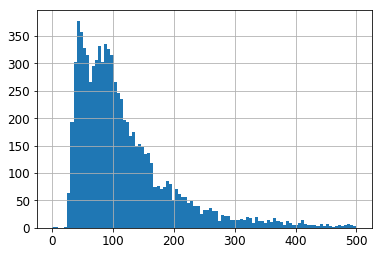

In [76]:
df['tneed'].hist(range=(0,500),bins=np.linspace(0,500,num=100))


In [77]:
df['tneed'][(df['tneed'] > 10) & (df['tneed'] < 500)].describe()

count    8321.000000
mean      118.911160
std        80.019627
min        24.580378
25%        63.289703
50%        96.857162
75%       147.672522
max       496.470644
Name: tneed, dtype: float64

# Create Test,Train sets

### Stratified smapling

In [78]:
np.random.seed(7)

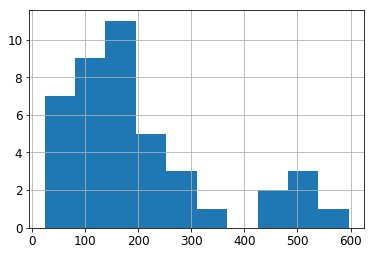

In [79]:
df['night_obs'].value_counts().hist()

In [80]:
# < 100 nights, so split train/test with stratified sampling
# the number of exposures in each night
# for key,val in zip(df['night_obs'].value_counts():
#     print(key,val)
vc= df['night_obs'].value_counts()
nexp_arr= np.zeros(len(df))-1
for night,nexp in zip(vc.index,vc.values):
    nexp_arr[ df['night_obs'] == night]= nexp
df= df.assign(nexp_this_night= nexp_arr)

In [81]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=7)
for train_index, test_index in split.split(df, df["nexp_this_night"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

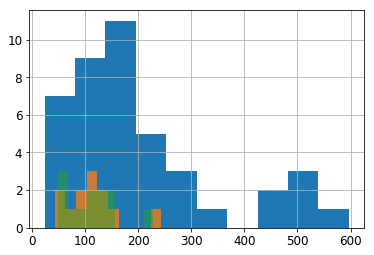

In [82]:
df["night_obs"].value_counts().hist()
strat_train_set["night_obs"].value_counts().hist(alpha=0.75)
strat_test_set["night_obs"].value_counts().hist(alpha=0.5)

### Random sampling

In [83]:
all_nights= list( set(df['night_obs']) )
i_nights= np.arange(len(all_nights))
np.random.shuffle(i_nights)
ihalf= len(all_nights)//2
i_nights_train,i_nights_test= i_nights[:ihalf], ind_nights[ihalf:]
# select all instances of these nights
keep_train,keep_test= np.zeros(len(df),bool),np.zeros(len(df),bool)
for i in i_nights_train:
    keep_train[ df['night_obs'] == all_nights[i]]=True
for i in i_nights_test:
    keep_test[ df['night_obs'] == all_nights[i]]=True
df_train, df_test= df.loc[keep_train], df.loc[keep_test] 

IndexError: list index out of range

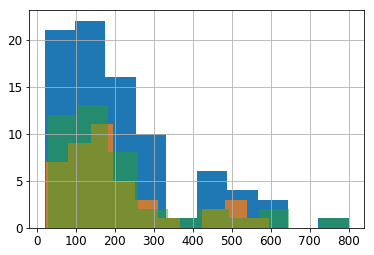

In [36]:
df["night_obs"].value_counts().hist()
df_train["night_obs"].value_counts().hist(alpha=0.75)
df_test["night_obs"].value_counts().hist(alpha=0.5)

# Look at Training

In [40]:
df_train.describe()

,id,expnum,exptime,mjd_obs,airmass,racenter,deccenter,rabore,decbore,ebv,...,affine_dxx,affine_dxy,affine_dy,affine_dyx,affine_dyy,affine_x0,affine_y0,night_obs,hr_obs,nexp_this_night
count,8455.000000,8455.000000,8455.000000,8455.000000,8455.000000,8455.000000,8455.000000,8455.000000,8455.000000,8455.000000,...,8455.000000,8455.000000,8455.000000,8455.000000,8455.000000,8455.000000,8455.000000,8.455000e+03,8455.000000,8455.000000
mean,12935.158131,553457.980958,109.134004,57570.443961,1.508743,207.449391,10.423903,207.031995,10.499814,0.050941,...,0.960976,-0.000869,-2.450415,0.002991,0.960802,887.717564,1871.508457,2.016119e+07,59129.819461,308.279953
std,8395.224632,102702.644519,49.023340,354.754562,0.324682,90.451814,12.174928,90.580255,12.175458,0.032641,...,0.194360,0.000968,217.611833,0.196930,0.194255,179.478037,378.380105,1.028600e+04,44321.711382,165.959907
min,8.000000,346575.000000,1.000000,56879.961850,0.000000,0.284103,-30.798992,0.000000,-30.723888,0.007810,...,0.000000,-0.003188,-20009.720835,-0.005316,0.000000,0.000000,0.000000,2.014081e+07,7.994000,24.000000
25%,4829.500000,509884.500000,74.000000,57397.317622,1.250000,153.810438,1.240855,153.593498,1.314000,0.028581,...,1.000127,-0.001639,-0.151416,0.000071,0.999964,924.000000,1948.000000,2.016011e+07,32537.709500,171.000000
50%,12097.000000,558520.000000,101.000000,57603.139249,1.430000,206.363404,9.446896,206.110996,9.522000,0.041904,...,1.000272,-0.000721,-0.049881,0.000692,1.000063,924.000000,1948.000000,2.016080e+07,54807.213000,270.000000
75%,21889.500000,649476.500000,135.000000,57893.178178,1.720000,256.774822,20.288798,256.312998,20.364000,0.063869,...,1.000446,-0.000082,0.006772,0.001586,1.000163,924.000000,1948.000000,2.017052e+07,74331.256000,485.000000
max,26278.000000,662432.000000,250.000000,57960.439112,2.490000,359.992468,33.926478,359.644004,33.996000,0.377127,...,1.002261,0.026863,0.729638,18.108579,1.001373,924.000000,1948.000000,2.017072e+07,235949.873000,597.000000


In [42]:
len(df_train),len(set(df_train['expnum']))

(8455, 8045)

In [43]:
df_train['night_obs'].value_counts().describe()

count     42.000000
mean     201.309524
std      148.524037
min       24.000000
25%      103.500000
50%      166.000000
75%      242.750000
max      597.000000
Name: night_obs, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116d377f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1194f48d0>]], dtype=object)

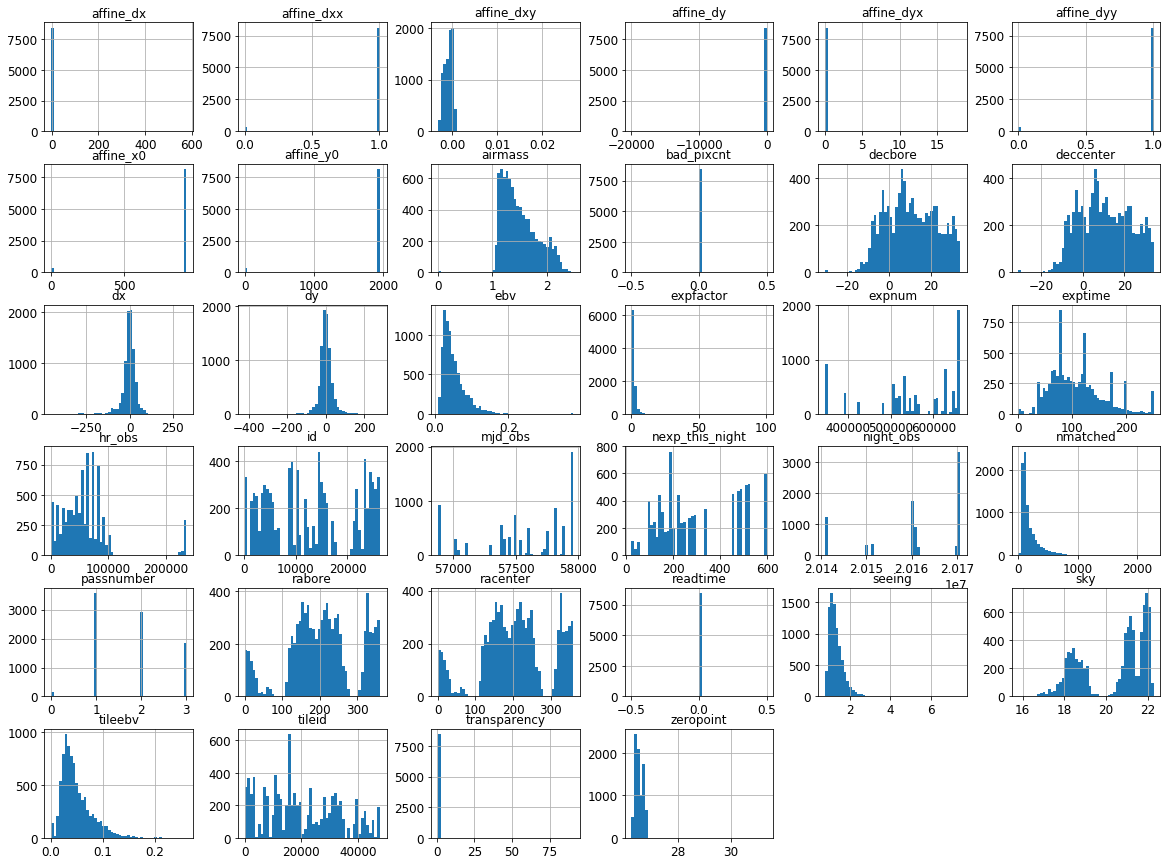

In [44]:
df_train.hist(bins=50, figsize=(20,15))
# save_fig("attribute_histogram_plots")
# plt.show()

In [48]:
corr_matrix = df_train.corr()
corr_matrix["expfactor"].sort_values(ascending=False)

expfactor          1.000000
seeing             0.401216
exptime            0.187366
ebv                0.144847
decbore            0.114338
deccenter          0.114325
tileid             0.103255
passnumber         0.098995
nexp_this_night    0.098742
airmass            0.095242
hr_obs             0.093963
tileebv            0.061794
dx                 0.054570
affine_x0          0.050160
affine_y0          0.050160
affine_dyy         0.050154
affine_dxx         0.050148
id                 0.030434
rabore             0.027988
racenter           0.027084
nmatched           0.019978
mjd_obs            0.005155
affine_dyx         0.004992
affine_dx          0.004435
affine_dxy         0.004384
expnum             0.002751
affine_dy         -0.004975
transparency      -0.008526
dy                -0.015129
night_obs         -0.017539
sky               -0.021671
zeropoint         -0.047506
bad_pixcnt              NaN
readtime                NaN
Name: expfactor, dtype: float64

/Users/kaylan1/miniconda3/envs/mlbook/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  import sys


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11741e2e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x124d49d68>]], dtype=object)

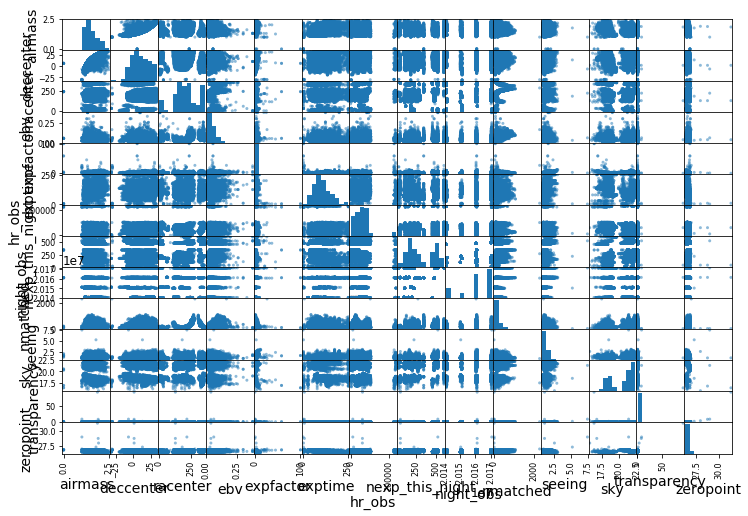

In [45]:
from pandas.tools.plotting import scatter_matrix

cols = ["airmass", "deccenter", "racenter",
        "ebv",'expfactor','exptime','hr_obs','nexp_this_night',
        'night_obs','nmatched','seeing','sky','transparency',
        'zeropoint']
scatter_matrix(df_train[cols], figsize=(12, 8))
# save_fig("scatter_matrix_plot")